In [8]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

import sys
sys.path.append("src/")
import gpt as g

from qcd_ml.nn.ptc import v_PTC
from qcd_ml.dirac import dirac_wilson_clover

SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

In [2]:
U = torch.tensor(np.load(os.path.join("test", "assets","1500.config.npy")))


In [3]:
paths = [[]] + [[(mu, 1)] for mu in range(4)] + [[(mu, -1)] for mu in range(4)]

idty = torch.complex(torch.tensor(np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]), dtype=torch.double)
                     , torch.zeros((4,4), dtype=torch.double))
zeros = torch.complex(torch.zeros((4,4), dtype=torch.double)
                     , torch.zeros((4,4), dtype=torch.double))

layer = v_PTC(1, 1, paths, U)
layer.weights.data[:,:,:] = zeros
layer.weights.data[:,:,0] = idty

In [4]:
vec = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

In [5]:
w = dirac_wilson_clover(U, -0.55, 1.0)


In [9]:
def lattice2ndarray(lattice):
    """ 
    Converts a gpt (https://github.com/lehner/gpt) lattice to a numpy ndarray 
    keeping the ordering of axes as one would expect.
    Example::
        q_top = g.qcd.gauge.topological_charge_5LI(U_smeared, field=True)
        plot_scalar_field(lattice2ndarray(q_top))
    """
    shape = lattice.grid.fdimensions
    shape = list(reversed(shape))
    if lattice[:].shape[1:] != (1,):
        shape.extend(lattice[:].shape[1:])
   
    result = lattice[:].reshape(shape)
    result = np.swapaxes(result, 0, 3)
    result = np.swapaxes(result, 1, 2)
    return result

def ndarray2lattice(ndarray, grid, lat_constructor):
    """
    Converts an ndarray to a gpt lattice, it is the inverse 
    of lattice2ndarray.

    Example::
        lat = ndarray2lattice(arr, g.grid([4,4,4,8], g.double), g.vspincolor)
    """
    lat = lat_constructor(grid)
    data = np.swapaxes(ndarray, 0, 3)
    data = np.swapaxes(data, 1, 2)
    lat[:] = data.reshape([data.shape[0] * data.shape[1] * data.shape[2] * data.shape[3]] + list(data.shape[4:]))
    return lat

In [17]:

U_gpt = g.load("/home/knd35666/data/ensembles/ens_001/1500.config/")
w_gpt = g.qcd.fermion.wilson_clover(U_gpt, {"mass": -0.55,
    "csw_r": 0.0,
    "csw_t": 0.0,
    "xi_0": 1.0,
    "nu": 1.0,
    "isAnisotropic": False,
    "boundary_phases": [1,1,1,1]})

w = lambda x: torch.tensor(lattice2ndarray(w_gpt(ndarray2lattice(x.numpy(), U_gpt[0].grid, g.vspincolor))))


GPT :     256.466620 s : Reading /home/knd35666/data/ensembles/ens_001/1500.config/
GPT :     256.471780 s : Switching view to [1,1,1,1]/Read
GPT :     256.498080 s : Read 0.00109863 GB at 0.0417652 GB/s (0.431946 GB/s for distribution, 0.0462437 GB/s for reading + checksum, 3.31988 GB/s for checksum, 1 views per node)
GPT :     256.511922 s : Read 0.00109863 GB at 0.0823386 GB/s (3.98271 GB/s for distribution, 0.0840968 GB/s for reading + checksum, 1.33295 GB/s for checksum, 1 views per node)
GPT :     256.525701 s : Read 0.00109863 GB at 0.082142 GB/s (3.64269 GB/s for distribution, 0.0840569 GB/s for reading + checksum, 3.22915 GB/s for checksum, 1 views per node)
GPT :     256.539492 s : Read 0.00109863 GB at 0.0881846 GB/s (3.27505 GB/s for distribution, 0.0906462 GB/s for reading + checksum, 3.68345 GB/s for checksum, 1 views per node)
GPT :     256.539905 s : Completed reading /home/knd35666/data/ensembles/ens_001/1500.config/ in 0.0742853 s


In [18]:
import time

start = time.perf_counter_ns()
w(vec)
stop = time.perf_counter_ns()
print((stop - start) / 1000 / 1000)

16.142126


In [19]:

def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()
    

In [20]:
def l2norm(v):
    return (v * v.conj()).real.sum()

In [21]:
def GMRES_torch(A, b, x0, maxiter=1000, eps=1e-4
              , innerproduct=None
              , prec=None):
    """
    GMRES solver using numpy backend.
    
    innerproduct is a function (vec,vec)->scalar which is a product.
    prec is a function vec->vec.

    Literature:
    - https://en.wikipedia.org/wiki/Generalized_minimal_residual_method
    - https://www-users.cse.umn.edu/~saad/Calais/PREC.pdf

    Authors:
    - Daniel Knüttel 2024
    """
    if hasattr(A, "__call__"):
        apply_A = lambda x: A(x)
    else:
        apply_A = lambda x: A @ x

    if innerproduct is None:
        innerproduct = lambda x,y: (x.conj() * y).sum()

    
    rk = b - apply_A(x0)

    b_norm = np.sqrt(innerproduct(b, b).real)
    
    rk_norm = np.sqrt(innerproduct(rk, rk).real)
    if rk_norm <= eps:
        return x0, {"converged": True, "k": 0}

    vk = rk / rk_norm

    v = [None, vk]
    
    cs = np.zeros(maxiter + 2, np.complex128)
    sn = np.zeros(maxiter + 2, np.complex128)
    gamma = np.zeros(maxiter + 2, np.complex128)
    gamma[1] = rk_norm
    H = [None]
    
    converged = False
    for k in range(1, maxiter + 1):
        if prec is not None:
            z = prec(v[k])
        else:
            z = v[k]
        qk = apply_A(z)
        
        Hk = np.zeros(k + 2, np.complex128)
        for i in range(1, k + 1):
            Hk[i] = innerproduct(v[i], qk)
        for i in range(1, k + 1):
            qk -= Hk[i] * v[i]
            
        Hk[k+1] = np.sqrt(innerproduct(qk, qk).real)
        v.append(qk / Hk[k+1])

        for i in range(1, k):
            # (c   s ) [a]   [a']
            # (-s* c*) [b] = [b']
            tmp = cs[i+1] * Hk[i] + sn[i+1] * Hk[i+1]
            Hk[i+1] = -np.conj(sn[i+1]) * Hk[i] + np.conj(cs[i+1]) * Hk[i+1]
            Hk[i] = tmp
            

        beta = np.sqrt(np.abs(Hk[k])**2 + np.abs(Hk[k + 1])**2)

        # ( c    s )[a]   [X]
        # (-s*   c*)[b] = [0]
        # is solved by 
        # s* = b; c* = a
        sn[k+1] = np.conj(Hk[k+1]) / beta
        cs[k+1] = np.conj(Hk[k]) / beta
        Hk[k] = cs[k+1] * Hk[k] + sn[k+1] * Hk[k+1]
        Hk[k+1] = 0
        
        
        gamma[k+1] = -np.conj(sn[k+1]) * gamma[k]
        gamma[k] = cs[k+1] * gamma[k]
        
        H.append(Hk)
        if np.abs(gamma[k+1]) / b_norm <= eps:
            converged = True
            break

    y = np.zeros(k+1, np.complex128)
    for i in reversed(range(1, k + 1)):
        overlap = 0
        for j in range(i+1, k+1):
            overlap += H[j][i] * y[j]
        y[i] = (gamma[i] - overlap) / H[i][i]
    if prec is None:
        x = x0 + sum(yi * vi for yi, vi in zip(y[1:], v[1:]))
    else:
        x = x0 + sum(yi * prec(vi) for yi, vi in zip(y[1:], v[1:]))
    return x, {"converged": converged, "k": k}


In [22]:
vec = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

x, ret = GMRES_torch(w, vec, vec, eps=1e-6, maxiter=500)

In [23]:
ret

{'converged': True, 'k': 91}

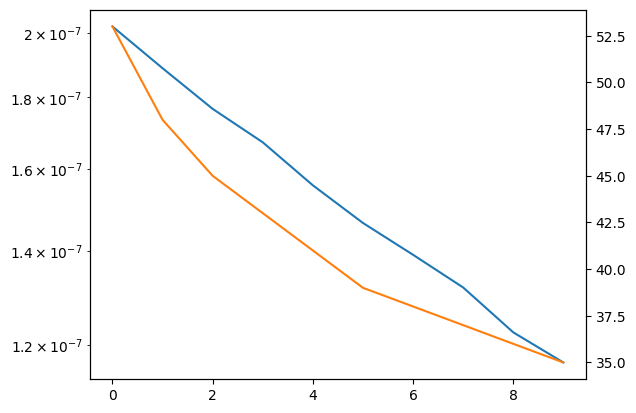

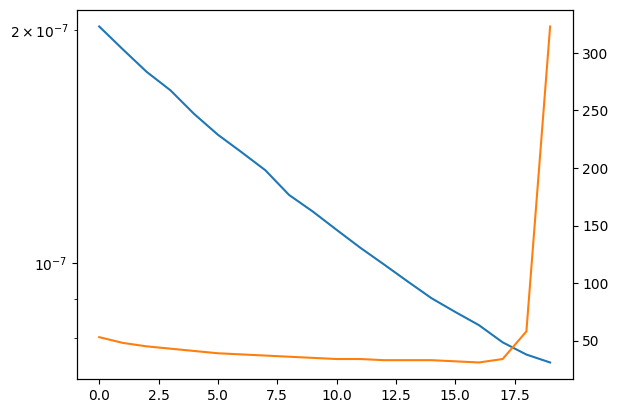

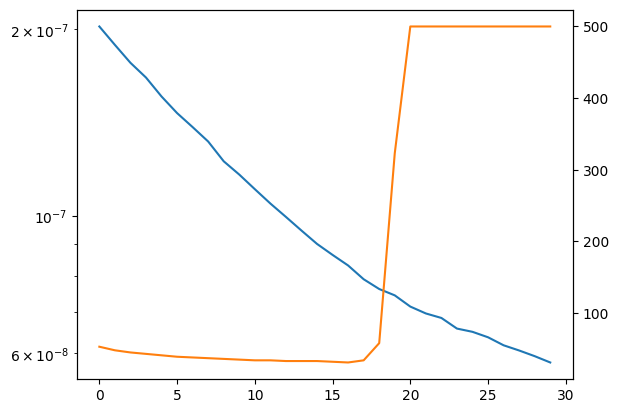

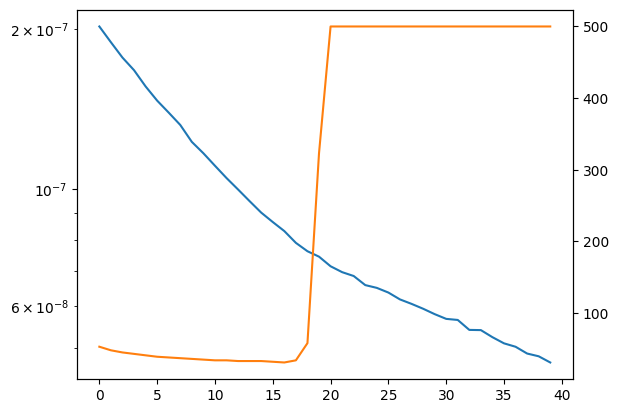

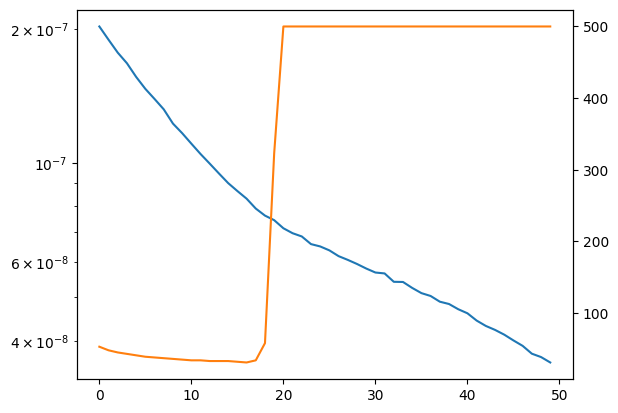

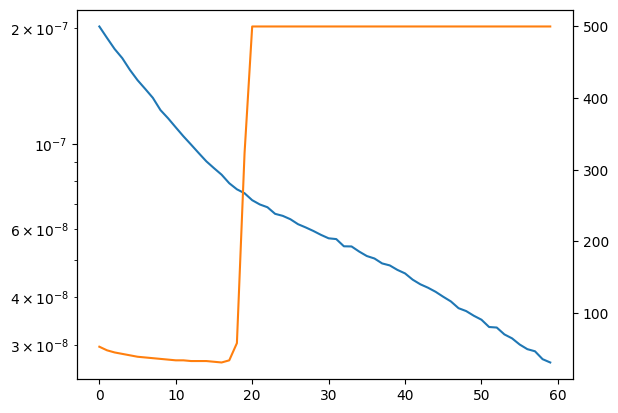

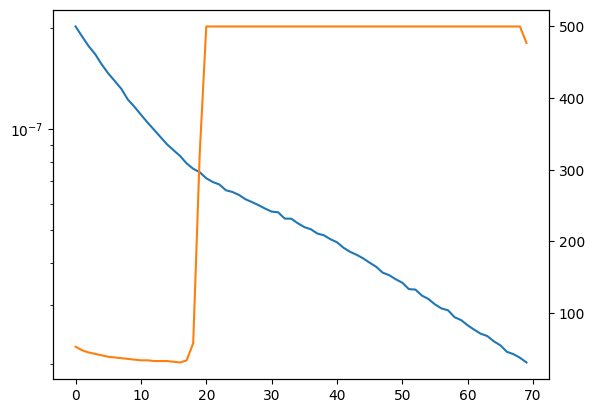

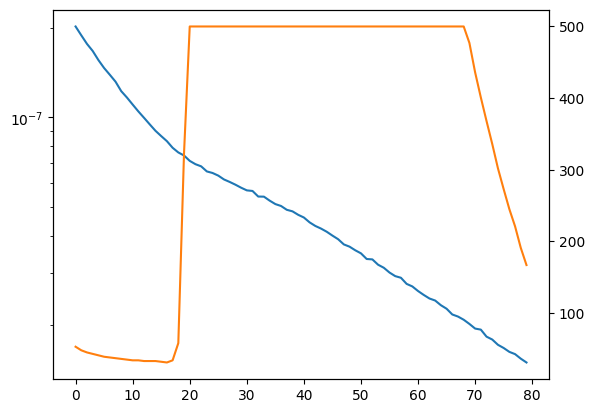

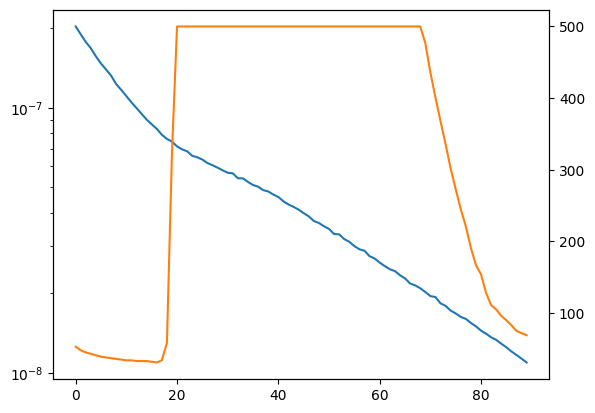

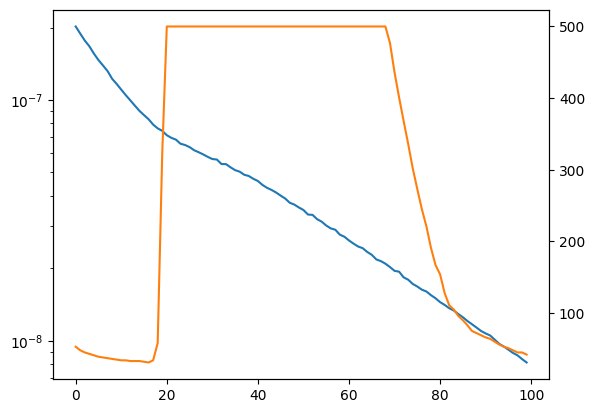

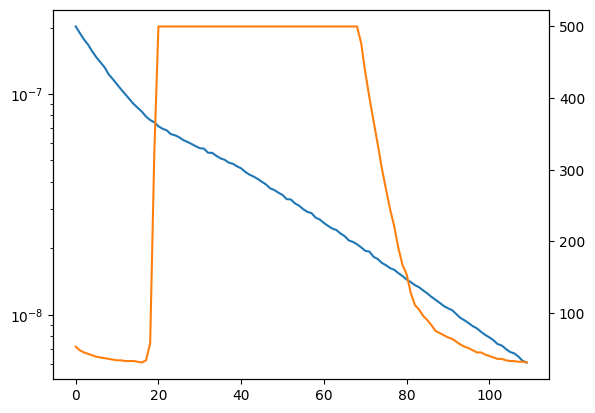

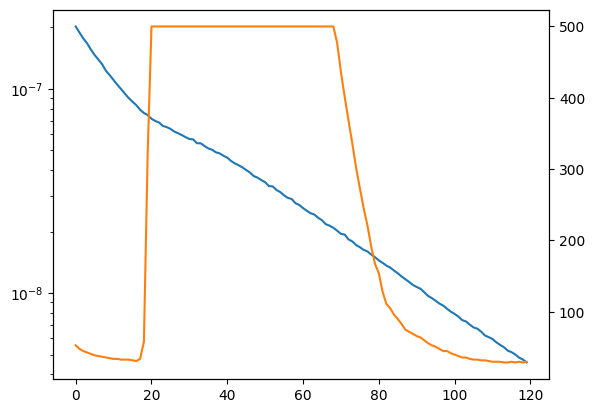

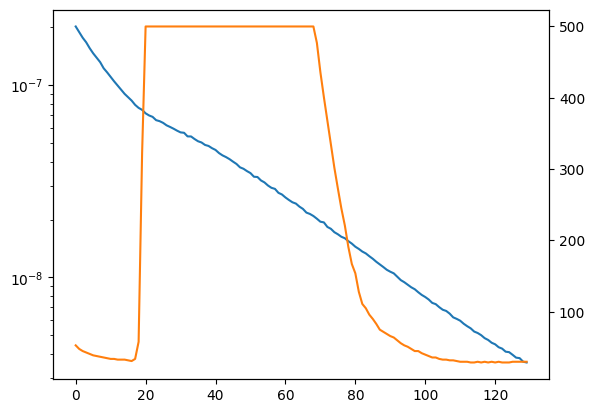

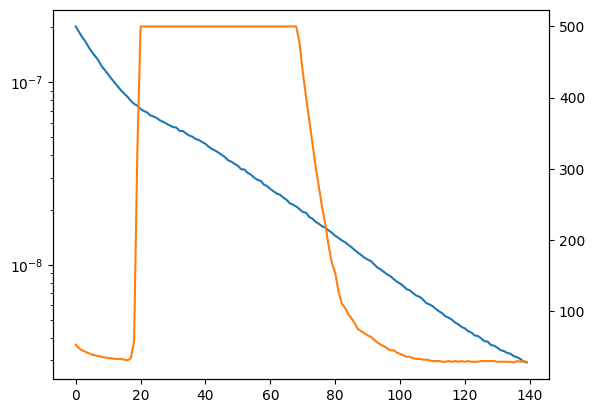

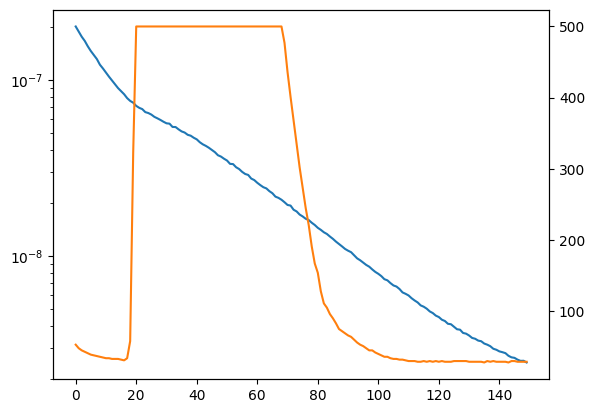

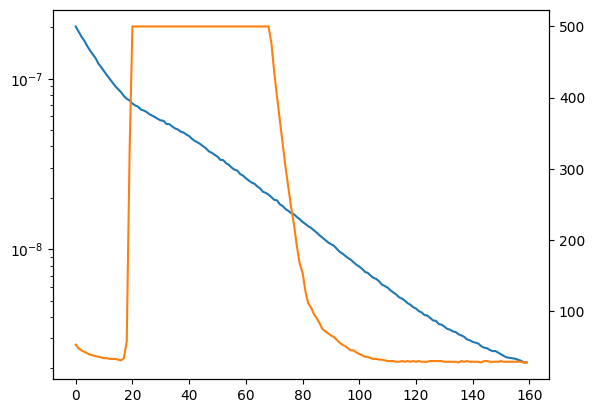

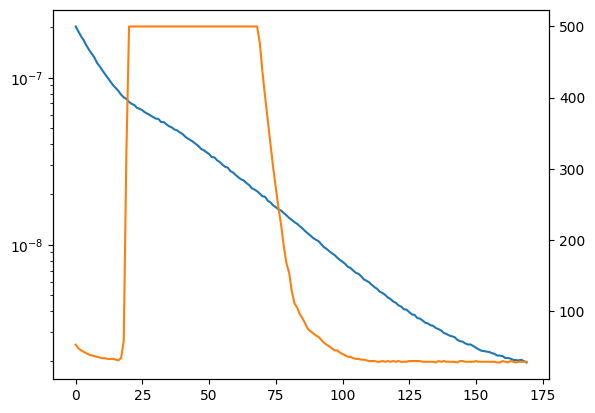

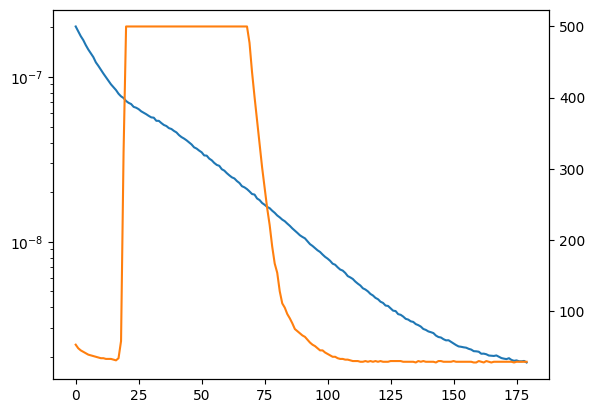

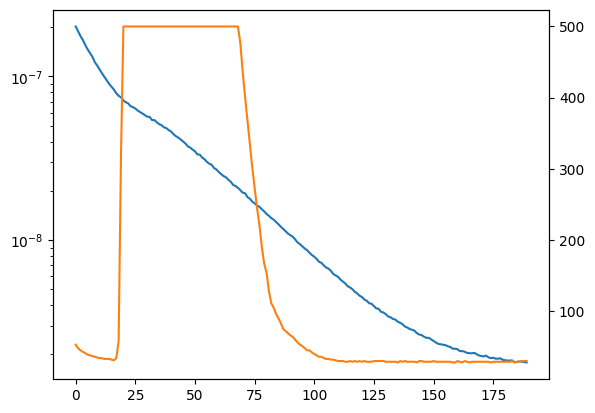

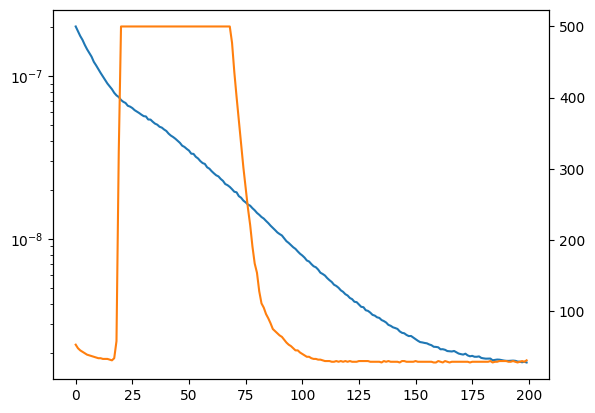

In [24]:
optimizer = torch.optim.Adam(layer.parameters(), lr=1e-2)

n_training = 200
check_every = 1
plot_every = 10

loss = np.zeros(n_training)
iterations_p = np.zeros(n_training // check_every)
ret_p = {"k": -1}

for t in range(1, n_training+1):
    vec = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))
    Dvec = w(vec)
    
    norm = l2norm(Dvec)
    Dvec = Dvec / norm
    vec = vec / norm
    
    sDvec = torch.stack([Dvec])
    score = complex_mse_loss(layer.forward(sDvec), torch.stack([vec]))
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    loss[t-1] = score.item()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    if t % check_every == 0:
        print(f"G [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
        with torch.no_grad():
            x_p, ret_p = GMRES_torch(w, vec, vec, prec=lambda v: layer.forward(torch.stack([v]))[0], eps=1e-4, maxiter=500)
    
        iterations_p[t // check_every - 1] = ret_p["k"]

    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    if t % plot_every == 0:
        plt.plot(loss[0:t])
        plt.yscale("log")
        ax = plt.gca().twinx()
        ax.plot(np.arange(0, n_training, check_every)[0:t//check_every], iterations_p[0:t//check_every], "C1")
        plt.show()

print()

Text(0, 0.5, 'iterations required by GMRES')

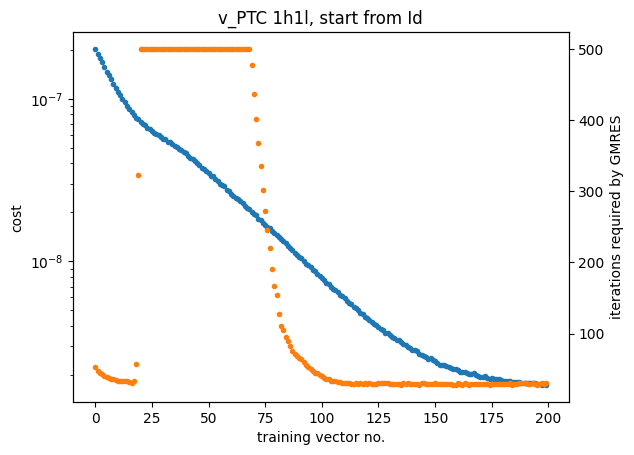

In [30]:
plt.plot(loss, ".")
plt.title("v_PTC 1h1l, start from Id")
plt.yscale("log")
plt.ylabel("cost")
plt.xlabel("training vector no.")
ax = plt.gca().twinx()
ax.plot(np.arange(0, n_training, check_every), iterations_p, "C1.")
ax.set_ylabel("iterations required by GMRES")

In [26]:
ret["k"] / ret_p["k"]

2.935483870967742

In [27]:
torch.save(list(layer.parameters()), "ptc1h1l_start_id.pt")